## Distibuted Training With Hyperparameter tuning and Generic Model Flavors

In [1]:
import numpy as np
import tensorflow as tf
import mlflow
import time
import json
from sys import version_info
from mlflow.models import infer_signature
print("TF Version :", tf.__version__)

TF Version : 2.19.0


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ds_with_mlflow_flavor").master("spark://spark-master:7077") \
        .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/06 13:58:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
mlflow_uri = "http://mlflow-server:8888"
mlflow.set_tracking_uri(mlflow_uri)
time.sleep(5)
#mlflow.set_experiment(mlflow_uri)
mlflow.set_experiment("ds_with_mlflow_flavor")

<Experiment: artifact_location='mlflow-artifacts:/791152268774684723', creation_time=1749216281462, experiment_id='791152268774684723', last_update_time=1749216281462, lifecycle_stage='active', name='ds_with_mlflow_flavor', tags={}>

In [4]:
# load dataset
mnist = tf.keras.datasets.mnist

(x_train, y_train) , (x_test,y_test) = mnist.load_data()
x_train,x_test =  x_train/255.0 , x_test/255.0

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


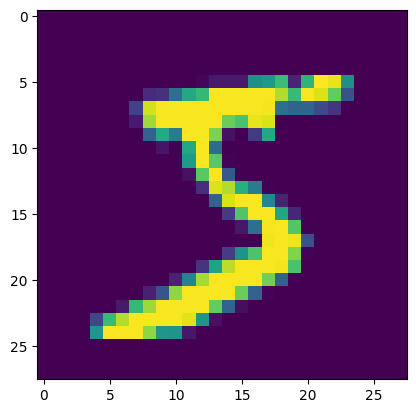

In [5]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

In [6]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt import SparkTrials, Trials

spark_trails = Trials()

In [7]:
from sys import version_info
conda_env_tf = {
    "channels": ["defaults"],
    "dependencies": [
        f"python={version_info.major}.{version_info.minor}.{version_info.micro}",
        "pip",
        {"pip": ["mlflow",
                 f"tensorflow=={tf.__version__}"]
        },
    ],
    "name": "tf_env"
}
conda_env_tf

{'channels': ['defaults'],
 'dependencies': ['python=3.11.13',
  'pip',
  {'pip': ['mlflow', 'tensorflow==2.19.0']}],
 'name': 'tf_env'}

In [8]:
import json
class custom_tf_model(mlflow.pyfunc.PythonModel):
    def __init__(self,params):
        self.params = params
        self.tf_model = None
        self.config = None

    def load_context(self, context = None, config_path = None):
        if context:
            config_path = context.artifacts["config_path"]
            
        else:
            pass
        self.config = json.load(open(config_path))

    
    def fit(self,x_train,y_train):

        tf_model = self.create_model(p_optimizer=self.config["optimizer"],
                                     l1_noNode=self.config["l1_noNode"],
                                     l1_activation = self.config["l1_activation"],
                                     l1_dropout = self.config["l1_dropout"])

        print(x_train.shape)
        tf_model.fit(x_train,y_train,epochs = self.params["epochs"])
        self.tf_model = tf_model


    def predict(self,context, model_input):
        
        return self.tf_model.predict(model_input)
    
    def evaluate(self,context,test_x,test_y):
        eval_loss, eval_acc = self.tf_model.evaluate(x_test,y_test,verbose=2)
        return eval_loss, eval_acc


    def create_model(self,p_optimizer = "Adam", l1_noNode= 32, l1_activation="relu",l1_dropout= 0.2):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(l1_noNode,activation=l1_activation),
            tf.keras.layers.Dropout(l1_dropout),
            tf.keras.layers.Dense(10)
        ])

        loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model.compile(optimizer = p_optimizer,loss= loss_func, metrics = ['accuracy'])

        return model
    





/usr/local/lib/python3.11/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [9]:
def train_with_hyperopt(params):
    with mlflow.start_run(nested=True) as run1 :
        p_epoch = params["epochs"]
        p_optimizer = params["optimizer"]
        l1_noNode = params["l1_noNode"]
        l1_activation = params["l1_activation"]
        l1_dropout  = params["l1_dropout"]


        mlflow.log_params(params)

        # create the configfile
        config_path = "data_tf.json"
        artifacts_tf = {"config_path" : config_path}   
        with open(config_path,"w") as f:
            json.dump(params,f)
        
        # create generic model
        params_ = {"epochs" : 5}
        config_path = "data_tf.json"
        custom_tf_model_obj = custom_tf_model(params_)
        custom_tf_model_obj.load_context(config_path=config_path)
        custom_tf_model_obj.fit(x_train=x_train,y_train=y_train)

        # Calculate LOSS and Acc
        eval_loss, eval_acc = custom_tf_model_obj.evaluate(context=None,
                                                           test_x=x_test,
                                                           test_y=y_test)

     
        mlflow.log_metric("eval_loss",eval_loss)
        mlflow.log_metric("eval_acc",eval_acc)


        # Prepare to generic model
        predictions_tf = custom_tf_model_obj.predict(context=None,model_input=x_test)
        model_signature = infer_signature(x_test,predictions_tf)
        mlflow.pyfunc.log_model(
            "custom_tf",
            python_model = custom_tf_model_obj,
            artifacts = artifacts_tf,
            conda_env = conda_env_tf,
            signature = model_signature,
            input_example = x_train[0:5]
        )


    return {"loss" : eval_loss, "status" : STATUS_OK, "model" : custom_tf_model_obj, "eval_acc":eval_acc, "run_id": run1.info.run_id  
}
        

In [10]:
epochs = [2,4,6,8]
optimizer = ["Adam","SGD","RMSprop"]
l1_noNode = [32,64,128]
l1_activation = ["relu","tanh","softmax"]
l1_dropout = [0.2,0.3,0.6]


search_params_space = {
    "epochs" : hp.choice("epochs",epochs),
    "optimizer" : hp.choice("optimizer",optimizer),
    "l1_noNode" : hp.choice("l1_noNode",l1_noNode),
    "l1_activation" : hp.choice("l1_activation",l1_activation),
    "l1_dropout" : hp.choice("l1_dropout",l1_dropout)
}

algo = tpe.suggest


In [11]:
algo

<function hyperopt.tpe.suggest(new_ids, domain, trials, seed, prior_weight=1.0, n_startup_jobs=20, n_EI_candidates=24, gamma=0.25, verbose=True)>

In [12]:
with mlflow.start_run() as run :
   args_min = fmin(
      fn=train_with_hyperopt,
      space=search_params_space,
      algo = algo,
      max_evals=3,
      trials=spark_trails
   )

2025/06/06 13:59:40 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



(60000, 28, 28)                                      
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1/5                                            

   1/1875 ━━━━━━━━━━━━━━━━━━━━ 8:15 265ms/step - accuracy: 0.1250 - loss: 2.3017
  35/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1615 - loss: 2.2961    
  72/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2143 - loss: 2.2875
 111/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2550 - loss: 2.2754
 146/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2760 - loss: 2.2637
 182/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2908 - loss: 2.2516
 227/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3031 - loss: 2.2367
 272/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3116 - loss: 2.2222
 316/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3176 - loss: 2.2084
 363/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3226 - loss: 2.1941
 409/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3265 - loss: 2.1806
 454/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3299 - loss: 2.1680
 498/1875 ━━━

2025/06/06 13:59:52 INFO mlflow.pyfunc: Validating input example against model signature

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

🏃 View run legendary-crow-597 at: http://mlflow-server:8888/#/experiments/791152268774684723/runs/1371118d15974076abc73e71b0bd1236

🧪 View experiment at: http://mlflow-server:8888/#/experiments/791152268774684723

(60000, 28, 28)                                                                
 33%|███▎      | 1/3 [00:12<00:25, 12.56s/trial, best loss: 0.4684818983078003]

/usr/local/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1/5                                                                      

   1/1875 ━━━━━━━━━━━━━━━━━━━━ 6:12 199ms/step - accuracy: 0.0938 - loss: 2.3009
  70/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.2218 - loss: 2.2795  
 148/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.2720 - loss: 2.2516
 223/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.2948 - loss: 2.2242
 292/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - accuracy: 0.3084 - loss: 2.2017
 364/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.3191 - loss: 2.1796
 438/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.3278 - loss: 2.1580
 507/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.3347 - loss: 2.1394
 578/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.3408 - loss: 2.1216
 655/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.3464 - loss: 2.1035
 734/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.3515 - loss: 2.0859
 810/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step -

2025/06/06 14:00:00 INFO mlflow.pyfunc: Validating input example against model signature



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step        
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step        

🏃 View run zealous-worm-828 at: http://mlflow-server:8888/#/experiments/791152268774684723/runs/690f39140d4a47138de8a25145c4620b

🧪 View experiment at: http://mlflow-server:8888/#/experiments/791152268774684723

(60000, 28, 28)                                                                
 67%|██████▋   | 2/3 [00:20<00:09,  9.71s/trial, best loss: 0.4684818983078003]

/usr/local/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1/5                                                                      

   1/1875 ━━━━━━━━━━━━━━━━━━━━ 5:38 181ms/step - accuracy: 0.0625 - loss: 2.3897
  52/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step - accuracy: 0.5040 - loss: 1.6303  
 108/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - accuracy: 0.6144 - loss: 1.3265
 168/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - accuracy: 0.6701 - loss: 1.1491
 229/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step - accuracy: 0.7049 - loss: 1.0323
 288/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.7285 - loss: 0.9516
 349/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - accuracy: 0.7466 - loss: 0.8887
 410/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - accuracy: 0.7607 - loss: 0.8393
 469/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - accuracy: 0.7720 - loss: 0.7993
 529/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - accuracy: 0.7815 - loss: 0.7649
 590/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.7898 - loss: 0.7349
 652/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step -

2025/06/06 14:00:10 INFO mlflow.pyfunc: Validating input example against model signature



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step        
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step        

🏃 View run silent-doe-583 at: http://mlflow-server:8888/#/experiments/791152268774684723/runs/7162292e2b3b4200bd90b4924c0797d9

🧪 View experiment at: http://mlflow-server:8888/#/experiments/791152268774684723

100%|██████████| 3/3 [00:30<00:00, 10.02s/trial, best loss: 0.09196963906288147]
🏃 View run handsome-penguin-552 at: http://mlflow-server:8888/#/experiments/791152268774684723/runs/c06a512468274d40a587ca625356c7ac
🧪 View experiment at: http://mlflow-server:8888/#/experiments/791152268774684723


In [ ]:
### Generic model flavours

In [13]:
args_min

{'epochs': 1,
 'l1_activation': 0,
 'l1_dropout': 0,
 'l1_noNode': 2,
 'optimizer': 2}

In [14]:
import mlflow
# Get the actual run ID where model was logged
best_trial = spark_trails.best_trial
model_run_id = best_trial['result']['run_id']


loaded_model = mlflow.pyfunc.load_model(f'runs:/{model_run_id}/custom_tf')

# Predict on a Pandas DataFrame.
import pandas as pd
result = loaded_model.predict(x_test[:10])
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([[-2.07438412e+01, -2.68373718e+01, -1.43511953e+01,
        -1.31022997e+01, -3.17486744e+01, -2.07132778e+01,
        -3.98017273e+01,  2.21492028e+00, -2.11091900e+01,
        -1.50475225e+01],
       [-2.63567982e+01, -2.46835442e+01, -7.14326620e+00,
        -1.94634762e+01, -5.03084259e+01, -1.89139347e+01,
        -2.53687305e+01, -5.32230530e+01, -2.13532505e+01,
        -5.10502281e+01],
       [-1.51637983e+01, -1.50215961e-02, -8.67891026e+00,
        -1.12270765e+01, -9.26923084e+00, -1.25367041e+01,
        -1.12341452e+01, -7.03493595e+00, -7.61905003e+00,
        -1.36733227e+01],
       [-1.90891540e+00, -2.66366730e+01, -1.16486149e+01,
        -1.90971699e+01, -1.75488415e+01, -1.45749159e+01,
        -1.19489565e+01, -1.53349733e+01, -2.04615974e+01,
        -1.39360886e+01],
       [-1.34536943e+01, -2.51595230e+01, -1.31930084e+01,
        -1.71255360e+01, -5.45159817e-01, -1.49733658e+01,
        -1.33382006e+01, -9.11560154e+00, -1.51723700e+01,
        -7.

In [15]:
spark.stop()